<a href="https://colab.research.google.com/github/YanuarN/HarvestHeroes/blob/Iqbal/Machine%20Learning/Paddy_Desease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
























































































































































































































































































































































































































































































































































































# **Computer Vision: Paddy Disease Classification** 💻🔥

### **Model Input:**
To train the model, we need a dataset of images labeled with the diseases present in the photos. We obtained our dataset from a competition held on the Kaggle website, cited as follows:   

> Paddy Doctor, Pandarasamy Arjunan (Samy), Petchiammal. (2022). Paddy Doctor: Paddy Disease Classification

In this dataset, we only use 2 features:
1. image_id: The name of the photo file to be used as model input. The images have a shape of (480, 640).
2. label: The classification label of the disease in 10 categories, including healthy rice.

### **Model Output:**
The model will return a prediction in the form of a label feature based on the model's prediction of the image.

### **Algorithm Sequence to Build the Model:**
* Download the image dataset ([Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/data))
* Perform preprocessing and data understanding with EDA (Exploratory Data Analysis)
* Build a CNN model for image classification
* Perform prediction and export to TF_JS (by CC's request)

### **Ensuring Access to Colab GPU:**
Using a GPU will be very helpful in speeding up the process of building the model and predicting with a large amount of data.


In [ ]:
# Mount Drive to Colab using colab API
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ccb29ec6-d001-dd9e-1f59-7eed5376a329)


### **Import Library for our Project**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### **Gathering Dataset**

In [ ]:
# Import Kaggle json token for downloading dataset
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Kaggle JSON/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading Dataset using Kaggle API
!kaggle competitions download -c paddy-disease-classification

100% 1.02G/1.02G [00:39<00:00, 32.6MB/s]
100% 1.02G/1.02G [00:39<00:00, 27.8MB/s]


In [ ]:
# Extract Dataset using unzip command to Datasets Directory
!mkdir Datasets
!unzip /content/paddy-disease-classification.zip -d /content/Datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/Datasets/train_images/downy_mildew/100992.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/100995.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101015.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101020.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101022.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101024.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101034.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101050.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101078.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101096.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101103.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101114.jpg  
  inflating: /content/Datasets/train_images/downy_mildew/101119.jpg  
  inflating: /content/Datasets/train_im

### **Data understanding and exploratory**

In [ ]:
TRAIN_CSV = "/content/Datasets/train.csv"
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
# Check distribution of labels in training data
train_df.label.value_counts()

label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64

In [ ]:
# Looking for missing value from our dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [ ]:
train_df.isna().sum()

image_id    0
label       0
variety     0
age         0
dtype: int64

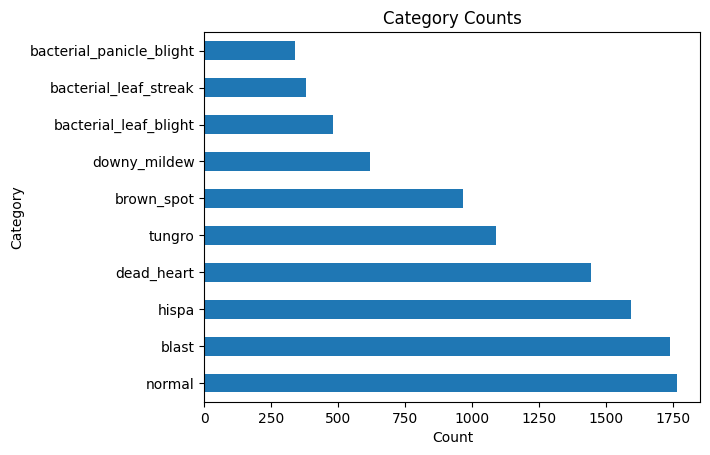

In [ ]:
# Check for distribution of out abstract lengths
disease_category = train_df['label'].value_counts()

# Plotting the histogram
disease_category.plot(kind='barh')
plt.ylabel('Category')
plt.xlabel('Count')
plt.title('Category Counts')
plt.show()

### **Preprocessing Data**

In [ ]:
TRAINING_DIR = '/content/Datasets/train_images'

# Data augmentation for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Data generator for the training data
train_generator = train_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Get label class name
train_label = train_generator.class_indices
print(train_label)

Found 9371 images belonging to 10 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


In [ ]:
# Data generator for the validation data
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)
val_generator = validation_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

val_label = val_generator.class_indices
print(val_label)

Found 1036 images belonging to 10 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


In [ ]:
# Callback for our train model
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs.get("accuracy") > 0.90) and (logs.get("val_accuracy") > 0.86):
            print("\nMinimum accuracy reached, stop training")
            self.model.stop_training = True

callback = myCallback()

### **Building train architecture model for our classification**

In [ ]:
model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_generator,
          epochs=30,
          validation_data=val_generator,
          callbacks=callback)

Epoch 1/30
293/293 [==============================] - 139s 468ms/step - loss: 2.2142 - accuracy: 0.3243 - val_loss: 1.6933 - val_accuracy: 0.4073
Epoch 2/30
293/293 [==============================] - 138s 473ms/step - loss: 1.5889 - accuracy: 0.4531 - val_loss: 1.5420 - val_accuracy: 0.4971
Epoch 3/30
293/293 [==============================] - 141s 482ms/step - loss: 1.3633 - accuracy: 0.5406 - val_loss: 1.3616 - val_accuracy: 0.5492
Epoch 4/30
293/293 [==============================] - 136s 465ms/step - loss: 1.1831 - accuracy: 0.6027 - val_loss: 1.3754 - val_accuracy: 0.5714
Epoch 5/30
293/293 [==============================] - 140s 478ms/step - loss: 1.0508 - accuracy: 0.6513 - val_loss: 1.0898 - val_accuracy: 0.6602
Epoch 6/30
293/293 [==============================] - 136s 464ms/step - loss: 0.9091 - accuracy: 0.6992 - val_loss: 1.0826 - val_accuracy: 0.6699
Epoch 7/30
293/293 [==============================] - 138s 470ms/step - loss: 0.8240 - accuracy: 0.7251 - val_loss: 1.0443 -

In [ ]:
# Save model to h5 format
model.save("model_Padi_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_images = []
image = tf.keras.preprocessing.image.load_img("/content/Datasets/test_images/200072.jpg", target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0
test_images.append(image)

test_images = np.array(test_images)

predictions = model.predict(test_images)
class_labels = np.argmax(predictions, axis=1)
print(class_labels)

1/1 [==============================] - 0s 61ms/step
[5]


1/1 [==============================] - 0s 30ms/step


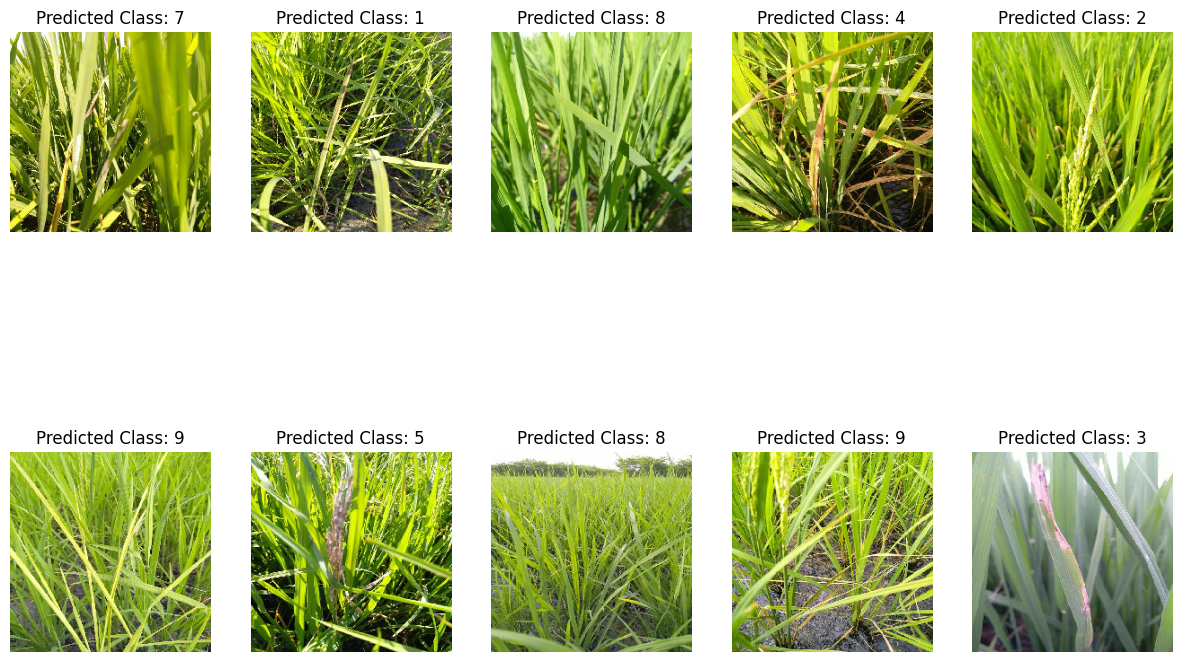

In [ ]:
import os
import random

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    return image

# Directory containing test images
test_images_dir = "/content/Datasets/test_images/"
test_image_paths = [os.path.join(test_images_dir, file) for file in os.listdir(test_images_dir)]

# Randomly select 10 image paths
random.seed(42)
random_image_paths = random.sample(test_image_paths, 10)

# Load and preprocess the 10 random images
test_images = [load_and_preprocess_image(image_path) for image_path in random_image_paths]
test_images = np.array(test_images)

# Predictions
predictions = model.predict(test_images)
class_labels = np.argmax(predictions, axis=1)

# Plot the images with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted Class: {class_labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# Convert model into TFJS
!pip install tensorflowjs==4.20

  Using cached tensorflowjs-4.20.0-py3-none-any.whl (89 kB)
  Using cached tensorflow_decision_forests-1.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.5 MB)
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Success

In [ ]:
!tensorflowjs_converter --input_format=keras model_Padi_2.h5 tfjs_model

2024-06-05 05:37:53.363418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 05:37:54.406160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
!zip -r '/content/tfjs_padi_model.zip' '/content/tfjs_model'

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard36of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard28of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard31of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard5of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard4of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard15of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard41of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard10of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard45of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard12of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard25of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard19of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard20of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard18of46.bin (deflated 7%)
  adding: content/tfjs_model/group1-

In [ ]:
!cp "/content/tfjs_padi_model.zip" "/content/drive/MyDrive/Kaggle JSON"
print("File copied successfully to Google Drive!")

File copied successfully to Google Drive!


In [ ]:
!cp "/content/model_Padi_1.h5" "/content/drive/MyDrive/Kaggle JSON"
!cp "/content/model_Padi_2.h5" "/content/drive/MyDrive/Kaggle JSON"
print("File copied successfully to Google Drive!")

File copied successfully to Google Drive!


In [ ]:
!cp -r "/content/tfjs_model" "/content/drive/MyDrive/Kaggle JSON"
print("File copied successfully to Google Drive!")

File copied successfully to Google Drive!
